In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scanpy
!pip install matplotlib==3.1.3

In [ ]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
Pancreas_adata = sc.read_text('/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_LogX_CellCycleRegressedOut.txt', delimiter = '\t', first_column_names=None)
sc.pp.scale(Pancreas_adata)
Pancreas_adata

AnnData object with n_obs × n_vars = 2209 × 26179
    var: 'mean', 'std'

In [ ]:
PancreasMetadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/PancreasMetadata.csv")
Pancreas_adata.obs['Cell Type'] = PancreasMetadata['Cell type'].values
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'unclassified exocrine', 'ductal',
       'δ', 'unclassified endocrine', 'endothelial', 'co-expression',
       'PSC', 'mast', 'MHC'], dtype=object)

In [ ]:
PancreasCellID = []
for item in PancreasMetadata['Cell ID'].values:
  PancreasCellID.append(item)
Pancreas_adata.obs_names = PancreasCellID
Pancreas_adata.obs_names

Index(['HP1502401_H13', 'HP1502401_J14', 'HP1502401_B14', 'HP1502401_A14',
       'HP1502401_C14', 'HP1502401_G14', 'HP1502401_E14', 'HP1502401_L14',
       'HP1502401_M14', 'HP1502401_K14',
       ...
       'HP1526901T2D_M7', 'HP1526901T2D_N16', 'HP1526901T2D_C8',
       'HP1526901T2D_H2', 'HP1526901T2D_I16', 'HP1526901T2D_F7',
       'HP1525301T2D_K3', 'HP1525301T2D_J10', 'HP1526901T2D_N8',
       'HP1526901T2D_A8'],
      dtype='object', length=2209)

In [ ]:
PancreasGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/Pancreas_Genelist.txt",header=None)
PancreasGenelist = []
for item in PancreasGenes.values.tolist():
  PancreasGenelist.append(item[0])
Pancreas_adata.var_names = PancreasGenelist
Pancreas_adata.var_names

Index(['SGIP1', 'AZIN2', 'CLIC4', 'AGBL4', 'NECAP2', 'SLC45A1', 'TGFBR3',
       'DBT', 'RFWD2', 'C1orf21',
       ...
       'KIR3DS1', 'KIR2DL5B', 'KIR2DS2', 'KIR2DS1', 'KIR2DL2', 'KIR2DL4',
       'KIR2DS3', 'KIR2DS2', 'BIVM-ERCC5', 'ERCC_30000:mix1_7500:mix2'],
      dtype='object', length=26179)

In [ ]:
# Exclude cells with cell type assignments that are not well-defined 
# i.e. unclassified exocrine, unclassified endocrine, co-expression, MHC
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified exocrine'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'unclassified endocrine'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'co-expression'))[0,:],:]
Pancreas_adata = Pancreas_adata[np.asarray(np.where(Pancreas_adata.obs['Cell Type'] != 'MHC'))[0,:],:]

print(Pancreas_adata.shape)
Pancreas_adata.obs['Cell Type'].unique()

(2122, 26179)


array(['γ', 'α', 'β', 'acinar', 'ε', 'ductal', 'δ', 'endothelial', 'PSC',
       'mast'], dtype=object)

In [ ]:
MarkerGeneList = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/PanglaoDB_Markers.tsv",sep='\t')

In [ ]:
PancreasMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['organ'] == 'Pancreas') & (MarkerGeneList['species'] != 'Mm')))[0,:],:]
PancreasMarkers

,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
5,Mm Hs,CELA3A,Acinar cells,ELA3|ELA3A,0.001,chymotrypsin like elastase family member 3A,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.128571,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6374,Mm Hs,LRRTM1,Peri-islet Schwann cells,FLJ32082,0.005,leucine rich repeat transmembrane neuronal 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.300000,0.001567,0.006292
6375,Mm Hs,SEMA3B,Peri-islet Schwann cells,SemA|semaV|LUCA-1|sema5|SEMAA,0.009,semaphorin 3B,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,0.000000,0.017549,0.000000
6376,Mm Hs,NGFR,Peri-islet Schwann cells,TNFRSF16|CD271|p75NTR,0.007,nerve growth factor receptor,protein-coding gene,NaN,Endoderm,Pancreas,1.000000,1.000000,0.001880,0.006806
6377,Mm Hs,PNLIPRP1,Peri-islet Schwann cells,PLRP1,0.008,pancreatic lipase related protein 1,protein-coding gene,NaN,Endoderm,Pancreas,0.000000,0.200000,0.001880,0.009310


In [ ]:
pd.unique(MarkerGeneList['cell type'])

array(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway epithelial cells',
       'Airway goblet cells', 'Airway smooth muscle cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       'Basal cells', 'Basophils', 'Bergmann glia', 'Beta cells',
       'Cajal-Retzius cells', 'Cardiac stem and precursor cells',
       'Cardiomyocytes', 'Cholangiocytes', 'Cholinergic neurons',
       'Chondrocytes', 'Choroid plexus cells', 'Chromaffin cells',
       'Ciliated cells', 'Clara cells', 'Crypt cells', 'Decidual cells',
       'Delta cells', 'Dendritic cells', 'Distal tubule cells',
       'Dopaminergic neurons', 'Ductal cells', 'Embryonic stem cells',
       'Endothelial cells', 'Endothelial cells (aorta)',
       'Endothelial cells (blood brain barrier)', 'Enteric glia cells',
       'Enteric neurons', 'Enterochromaffin cells', 'Enterocytes',
 

In [ ]:
pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic progenitor cells', 'Pancreatic stellate cells',
       'Peri-islet Schwann cells'], dtype=object)

In [ ]:
Pancreas_adata.obs['Cell Type'].unique()

array(['γ', 'α', 'β', 'acinar', 'ε', 'ductal', 'δ', 'endothelial', 'PSC',
       'mast'], dtype=object)

In [ ]:
# Manually get rid of unwanted cell types: Pancreatic progenitor cells and Peri-islet Schwann cells 
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Pancreatic progenitor cells'))[0,:],:]
PancreasMarkers = PancreasMarkers.iloc[np.asarray(np.where(PancreasMarkers['cell type'] != 'Peri-islet Schwann cells'))[0,:],:]

# Manually add cell types: endocrine, endothelial, mast, MHC (dendritic, macrophages, B cells)
# unclassified exocrine cells are also acinar cells; co-expression is not a defined cell type
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Enteroendocrine cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Endothelial cells'))[0,:],:])
PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Mast cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Dendritic cells'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'Macrophages'))[0,:],:])
# PancreasMarkers = PancreasMarkers.append(MarkerGeneList.iloc[np.asarray(np.where(MarkerGeneList['cell type'] == 'B cells'))[0,:],:])

pd.unique(PancreasMarkers['cell type'])

array(['Acinar cells', 'Alpha cells', 'Beta cells', 'Delta cells',
       'Ductal cells', 'Epsilon cells', 'Gamma (PP) cells',
       'Pancreatic stellate cells', 'Endothelial cells', 'Mast cells'],
      dtype=object)

In [ ]:
PanglaoDB_Pancreas = PancreasMarkers['official gene symbol']
PanglaoDB_Pancreas = list(set(PanglaoDB_Pancreas) & set(Pancreas_adata.var_names)) # overlap between dataset gene list and the PanglaoDB set 
len(PanglaoDB_Pancreas)

587

In [ ]:
PancreasMarkers.shape

(684, 14)

In [ ]:
# Pancreas_adata.write(filename="/content/drive/My Drive/ML4FG 2022/Data/Pancreas Data/Processed/Pancreas_CellCycleRegressedOut_AnnData.h5ad")

In [ ]:
# Create a variable list for input genes / features 

Panglao_Input = []

for i in range(Pancreas_adata.shape[1]):
  if Pancreas_adata.var_names[i] in set(PanglaoDB_Pancreas):
    Panglao_Input.append(True)
  else: 
    Panglao_Input.append(False)

Pancreas_adata.var['input_features'] = Panglao_Input
Pancreas_adata.var['input_features']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SGIP1                        False
AZIN2                        False
CLIC4                         True
AGBL4                        False
NECAP2                       False
                             ...  
KIR2DL4                      False
KIR2DS3                      False
KIR2DS2                      False
BIVM-ERCC5                   False
ERCC_30000:mix1_7500:mix2    False
Name: input_features, Length: 26179, dtype: bool

In [ ]:
# Create anndata input for the model by filtering Pancreas_adata

Pancreas_input = Pancreas_adata[:,Pancreas_adata.var['input_features']]
Pancreas_input

View of AnnData object with n_obs × n_vars = 2122 × 593
    obs: 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# device = 'cpu'

cuda


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
class Autoencoder(Model):
    def __init__(self, num_cell_types, num_genes, reg_penalties):
        super(Autoencoder, self).__init__()  
        self.reg_penalties = reg_penalties
        self.encoder = tf.keras.Sequential([
          layers.Dense(num_cell_types, activation='softmax', 
                       kernel_regularizer=self.marker_gene_regularizer, 
                       kernel_constraint=tf.keras.constraints.NonNeg()),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(num_genes, activation='linear')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def embed(self, x):
      encoded = self.encoder(x)
      return encoded

    def marker_gene_regularizer(self, w):
      return tf.reduce_sum(self.reg_penalties * tf.square(w))

In [ ]:
marker_genes = Pancreas_input.var_names
cell_types = pd.unique(PancreasMarkers['cell type'])

marker_gene_cell_type_reg_penalties = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      PancreasMarkers[(PancreasMarkers['official gene symbol'] == gene) & 
                      (PancreasMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # penalize weight lighly if marker gene
      marker_gene_cell_type_reg_penalties[i, j] = 0
    else:                              # penalize weight heavily if not marker gene
      marker_gene_cell_type_reg_penalties[i, j] = 1

print(marker_gene_cell_type_reg_penalties.shape)
marker_gene_cell_type_reg_penalties

(593, 10)


array([[1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [ ]:
NumPancreasCellTypes = len(Pancreas_adata.obs['Cell Type'].unique())
num_genes = Pancreas_input.shape[1]
autoencoder = Autoencoder(NumPancreasCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(Pancreas_input.X, Pancreas_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(Pancreas_input.X, Pancreas_input.X))

Epoch 1/25
67/67 [==============================] - 2s 16ms/step - loss: 4.6676 - val_loss: 1.6823
Epoch 2/25
67/67 [==============================] - 1s 12ms/step - loss: 1.1683 - val_loss: 0.9450
Epoch 3/25
67/67 [==============================] - 1s 12ms/step - loss: 0.9117 - val_loss: 0.8911
Epoch 4/25
67/67 [==============================] - 1s 12ms/step - loss: 0.8794 - val_loss: 0.8675
Epoch 5/25
67/67 [==============================] - 1s 12ms/step - loss: 0.8581 - val_loss: 0.8481
Epoch 6/25
67/67 [==============================] - 1s 12ms/step - loss: 0.8403 - val_loss: 0.8317
Epoch 7/25
67/67 [==============================] - 1s 8ms/step - loss: 0.8250 - val_loss: 0.8177
Epoch 8/25
67/67 [==============================] - 1s 9ms/step - loss: 0.8118 - val_loss: 0.8054
Epoch 9/25
67/67 [==============================] - 0s 6ms/step - loss: 0.8003 - val_loss: 0.7946
Epoch 10/25
67/67 [==============================] - 0s 7ms/step - loss: 0.7903 - val_loss: 0.7852
Epoch 11/25
6

Text(0.5, 0, 'Epochs')

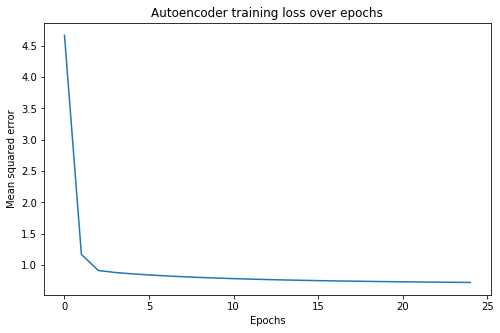

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

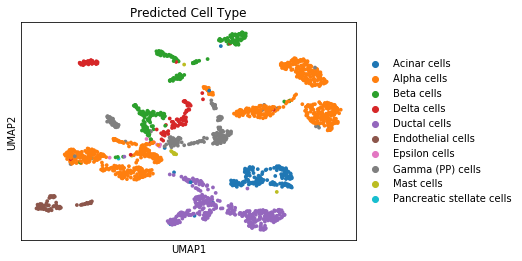

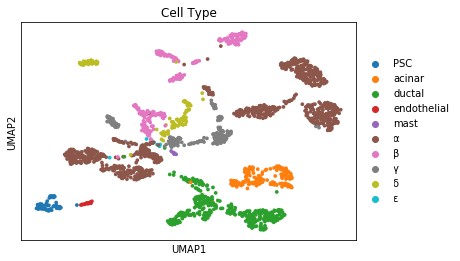

In [ ]:
latent_embedding = autoencoder.embed(Pancreas_input.X)
cell_type_labels = [cell_types[label] for label in 
                    tf.math.argmax(latent_embedding, axis=1).numpy()]

sc.tl.pca(Pancreas_adata, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(Pancreas_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(Pancreas_adata)

Pancreas_adata.obs['Predicted Cell Type'] = cell_type_labels
sc.pl.umap(Pancreas_adata, color=['Predicted Cell Type'])
sc.pl.umap(Pancreas_adata, color=['Cell Type'])

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/Pancreas Data/Processed/'
Pancreas_adata.obs.to_csv(dir + 'marker_reg_model_preds_pancreas.csv')

In [ ]:
# Read and process GBM data 

GBM_adata = sc.read_text("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GBM_LogX.txt", delimiter = '\t', first_column_names=None)
GBM_adata = GBM_adata.T 

# Regress out cell cycle scores
GBMCellCycleScores = pd.read_table("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/GbmCellCycleScores.txt", delimiter = '\t')
GBM_adata.obs['score_S'] = GBMCellCycleScores['score_S'].values
GBM_adata.obs['score_G2M'] = GBMCellCycleScores['score_G2M'].values
sc.pp.regress_out(GBM_adata, ['score_S', 'score_G2M'])

# Scale (zero-center) data
sc.pp.scale(GBM_adata)

GBM_Metadata = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/metadata2.csv")
GBM_adata.obs['Cell Type'] = GBM_Metadata['cell_assignment'].values

GBMGenes = pd.read_csv("/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/features2.tsv",header=None)
GBMGenelist = []
for item in GBMGenes.values.tolist():
  GBMGenelist.append(item[0])
GBM_adata.var_names = GBMGenelist
GBM_adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2MP1',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=23686)

In [ ]:
GBMMarkers = MarkerGeneList.iloc[np.asarray(np.where((MarkerGeneList['cell type'] == 'Oligodendrocytes') | 
                                                    (MarkerGeneList['cell type'] == 'T cells') |
                                                    (MarkerGeneList['cell type'] == 'Macrophages')))[0,:],:]

PanglaoDB_GBM = GBMMarkers['official gene symbol']
PanglaoDB_GBM = list(set(PanglaoDB_GBM) & set(GBM_adata.var_names))

# # Manually add malignant gene markers 
# MalignantGenes = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1','IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT','RAS','TERT']
# for g in MalignantGenes:
#   if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
#     PanglaoDB_GBM.append(g)

# Manually add malignant gene markers 
MalignantGenesPool = ['CD133','CD44','ABCC3','TNFRSF1A','MGMT','IDH 1','IDH 2','ATRX','1p/19q','TP53','RB','PI3K','RKT','RAS','TERT']
MalignantGenes = []
for g in MalignantGenesPool:
  if ((g in GBM_adata.var_names) & (g not in PanglaoDB_GBM)):
    MalignantGenes.append(g)
MalignantGenes

# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in set(PanglaoDB_GBM):
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [ ]:
Malignant_df = pd.DataFrame({"official gene symbol":MalignantGenes, "cell type":['Malignant']*len(MalignantGenes)})
Malignant_df

,official gene symbol,cell type
0,CD44,Malignant
1,ABCC3,Malignant
2,TNFRSF1A,Malignant
3,MGMT,Malignant
4,ATRX,Malignant
5,TP53,Malignant
6,TERT,Malignant


In [ ]:
len(PanglaoDB_GBM)

295

In [ ]:
PanglaoDB_GBM = PanglaoDB_GBM + list(Malignant_df['official gene symbol'])
len(PanglaoDB_GBM)

302

In [ ]:
GBMMarkers_list = []
for gene in PanglaoDB_GBM:
  if gene in list(GBMMarkers['official gene symbol']):
    GBMMarkers_list.append({
        'official gene symbol': gene,
        'cell type': GBMMarkers.loc[GBMMarkers['official gene symbol'] == gene, 'cell type'].iloc[0]
    })
        
GBMMarkers = pd.DataFrame(GBMMarkers_list)
print(GBMMarkers.shape)
GBMMarkers.head()

(295, 2)


,official gene symbol,cell type
0,SATB1,T cells
1,CD180,Macrophages
2,PTGDS,Oligodendrocytes
3,SKAP1,T cells
4,CD160,T cells


In [ ]:
GBMMarkers = pd.concat([GBMMarkers, Malignant_df])
print(GBMMarkers.shape)
GBMMarkers.head()

(302, 2)


,official gene symbol,cell type
0,SATB1,T cells
1,CD180,Macrophages
2,PTGDS,Oligodendrocytes
3,SKAP1,T cells
4,CD160,T cells


In [ ]:
# Create a variable list for input genes / features 
Panglao_GBM_Input = []

for i in range(GBM_adata.shape[1]):
  if GBM_adata.var_names[i] in PanglaoDB_GBM:
    Panglao_GBM_Input.append(True)
  else: 
    Panglao_GBM_Input.append(False)

GBM_adata.var['input_features'] = Panglao_GBM_Input

In [ ]:
# Create anndata input for the model by filtering GBM_adata
GBM_input = GBM_adata[:,GBM_adata.var['input_features']]
GBM_input

View of AnnData object with n_obs × n_vars = 7930 × 302
    obs: 'score_S', 'score_G2M', 'Cell Type'
    var: 'mean', 'std', 'input_features'

In [ ]:
cell_types = pd.unique(GBMMarkers['cell type'])
cell_types

array(['T cells', 'Macrophages', 'Oligodendrocytes', 'Malignant'],
      dtype=object)

In [ ]:
marker_genes = GBM_input.var_names
cell_types = pd.unique(GBMMarkers['cell type'])

marker_gene_cell_type_reg_penalties = np.zeros((len(marker_genes), len(cell_types)))
for i, gene in enumerate(marker_genes):
  for j, cell_type in enumerate(cell_types):
    is_marker_gene_for_cell_type = \
      GBMMarkers[(GBMMarkers['official gene symbol'] == gene) & 
                 (GBMMarkers['cell type'] == cell_type)].shape[0] > 0
    if is_marker_gene_for_cell_type:   # penalize weight lighly if marker gene
      marker_gene_cell_type_reg_penalties[i, j] = 0
    else:                              # penalize weight heavily if not marker gene
      marker_gene_cell_type_reg_penalties[i, j] = 10

print(marker_gene_cell_type_reg_penalties.shape)
marker_gene_cell_type_reg_penalties

(302, 4)


array([[10., 10., 10.,  0.],
       [10.,  0., 10., 10.],
       [10., 10.,  0., 10.],
       ...,
       [10., 10.,  0., 10.],
       [10.,  0., 10., 10.],
       [10., 10.,  0., 10.]])

In [ ]:
NumGBMCellTypes = len(GBM_input.obs['Cell Type'].unique())
num_genes = GBM_input.shape[1]
autoencoder = Autoencoder(NumGBMCellTypes, num_genes, 
                          marker_gene_cell_type_reg_penalties)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(GBM_input.X, GBM_input.X,
                          epochs=25,
                          shuffle=True,
                          validation_data=(GBM_input.X, GBM_input.X))

Epoch 1/25
248/248 [==============================] - 4s 13ms/step - loss: 6.0521 - val_loss: 0.9607
Epoch 2/25
248/248 [==============================] - 3s 13ms/step - loss: 0.9301 - val_loss: 0.9086
Epoch 3/25
248/248 [==============================] - 3s 12ms/step - loss: 0.8929 - val_loss: 0.8782
Epoch 4/25
248/248 [==============================] - 2s 10ms/step - loss: 0.8671 - val_loss: 0.8564
Epoch 5/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8481 - val_loss: 0.8400
Epoch 6/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8337 - val_loss: 0.8274
Epoch 7/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8226 - val_loss: 0.8175
Epoch 8/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8138 - val_loss: 0.8097
Epoch 9/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8067 - val_loss: 0.8031
Epoch 10/25
248/248 [==============================] - 2s 6ms/step - loss: 0.8007 - val_loss: 0.

Text(0.5, 0, 'Epochs')

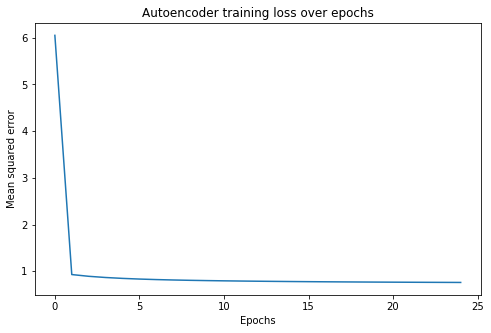

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Autoencoder training loss over epochs')
plt.ylabel('Mean squared error')
plt.xlabel('Epochs')

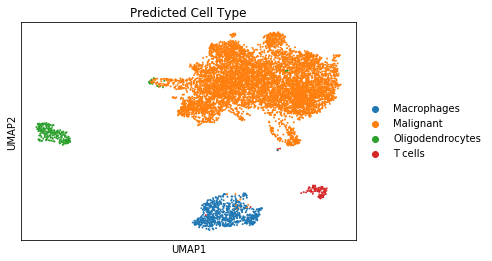

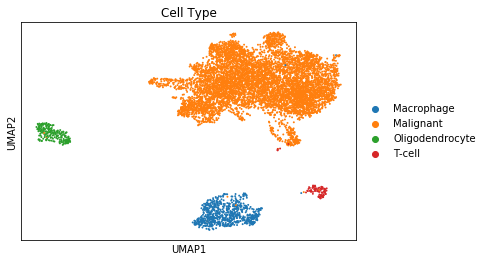

In [ ]:
latent_embedding = autoencoder.embed(GBM_input.X)
cell_type_labels = []
for item in latent_embedding:
  cell_type_labels.append(cell_types[np.where(item == max(item))[0][0]])

sc.tl.pca(GBM_input, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(GBM_input, n_neighbors=10, n_pcs=40)
sc.tl.umap(GBM_input)

GBM_input.obs['Predicted Cell Type'] = cell_type_labels
sc.pl.umap(GBM_input, color=['Predicted Cell Type'])
sc.pl.umap(GBM_input, color=['Cell Type'])

In [ ]:
marker_gene_cell_type_reg_penalties

array([[10., 10., 10.,  0.],
       [10.,  0., 10., 10.],
       [10., 10.,  0., 10.],
       ...,
       [10., 10.,  0., 10.],
       [10.,  0., 10., 10.],
       [10., 10.,  0., 10.]])

In [ ]:
autoencoder.layers[0].weights[0]

<tf.Variable 'dense_4/kernel:0' shape=(302, 4) dtype=float32, numpy=
array([[ 1.1445621e-04,  1.5284591e-04, -0.0000000e+00, -0.0000000e+00],
       [ 4.8064903e-06, -0.0000000e+00,  1.6869665e-06, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00,  6.0274098e-02, -0.0000000e+00],
       ...,
       [-0.0000000e+00, -0.0000000e+00,  3.0141766e-03, -0.0000000e+00],
       [ 1.4021436e-05,  7.0416592e-02,  1.2039600e-06,  3.2480448e-04],
       [ 2.7045087e-05, -0.0000000e+00,  4.3581489e-02, -0.0000000e+00]],
      dtype=float32)>

In [ ]:
dir = '/content/drive/MyDrive/ML for genomics project group /Data/GBM Data/Processed/'
GBM_input.obs.to_csv(dir + 'marker_reg_model_preds_gbm.csv')